In [1]:
# %%
import numpy as np
import scvelo as scv
import torch
from scipy.stats import mannwhitneyu

from deepvelo.utils import velocity, velocity_confidence, latent_time, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants


# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

%load_ext autoreload
%autoreload 2


Using backend: pytorch


# Load EP data and preprocess

In [2]:
adata = scv.datasets.pancreas()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)


The ratio of spliced reads is 83.2% (between 70% and 85%). Suggest using coeff_s 0.75.


In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)


computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([3696, 2000])


velo_mat shape: (3696, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [5]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


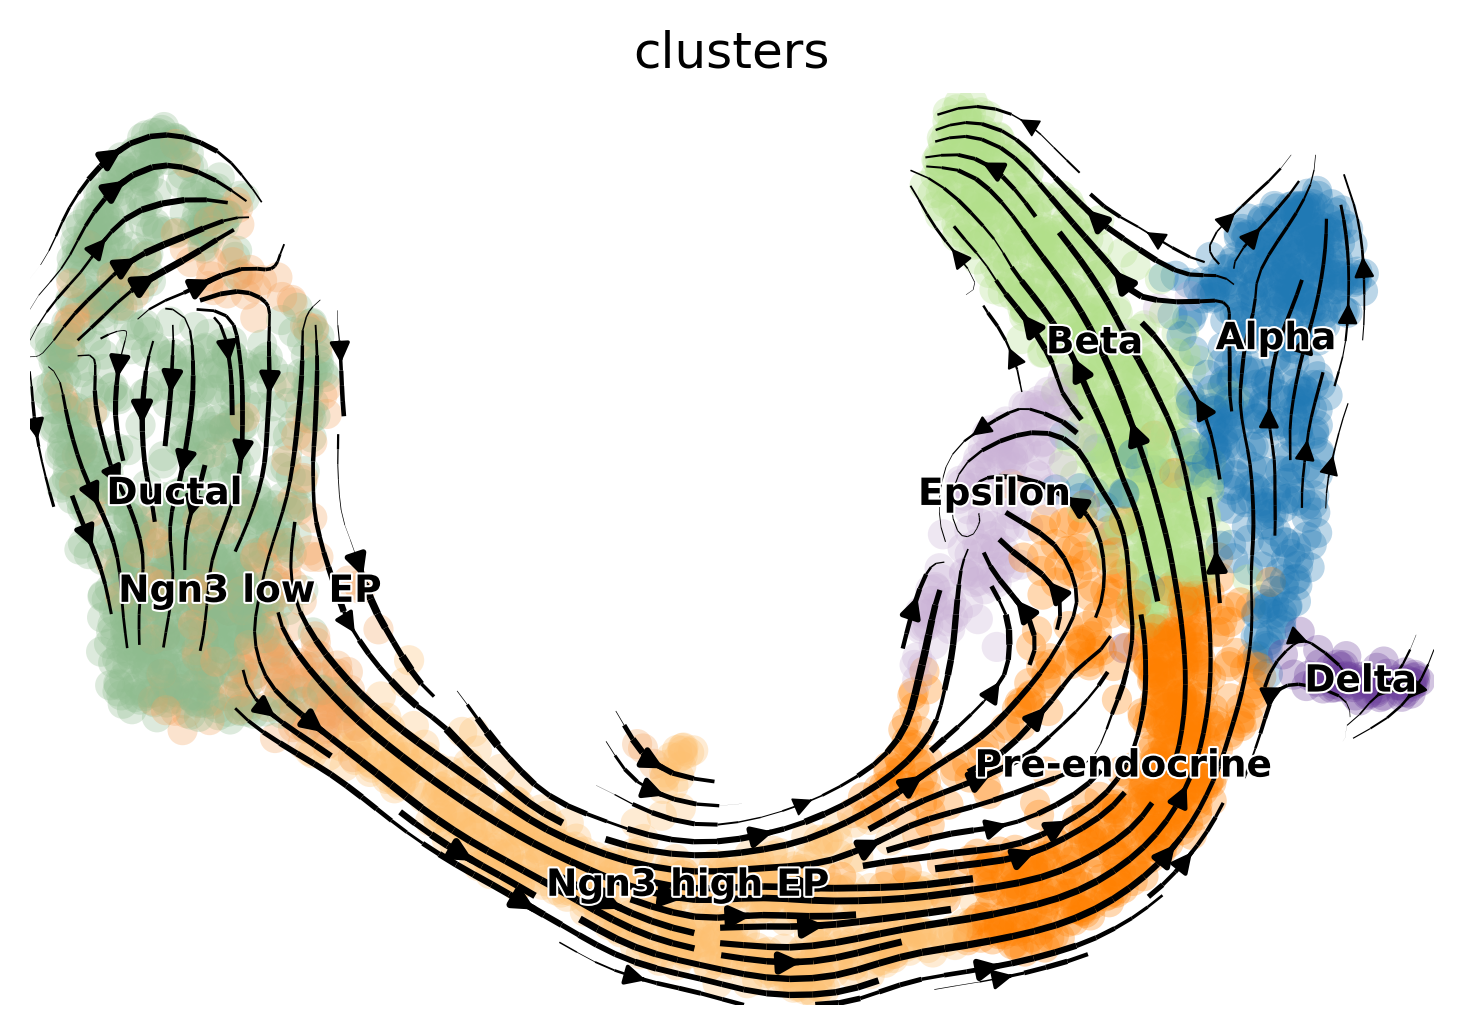

In [6]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


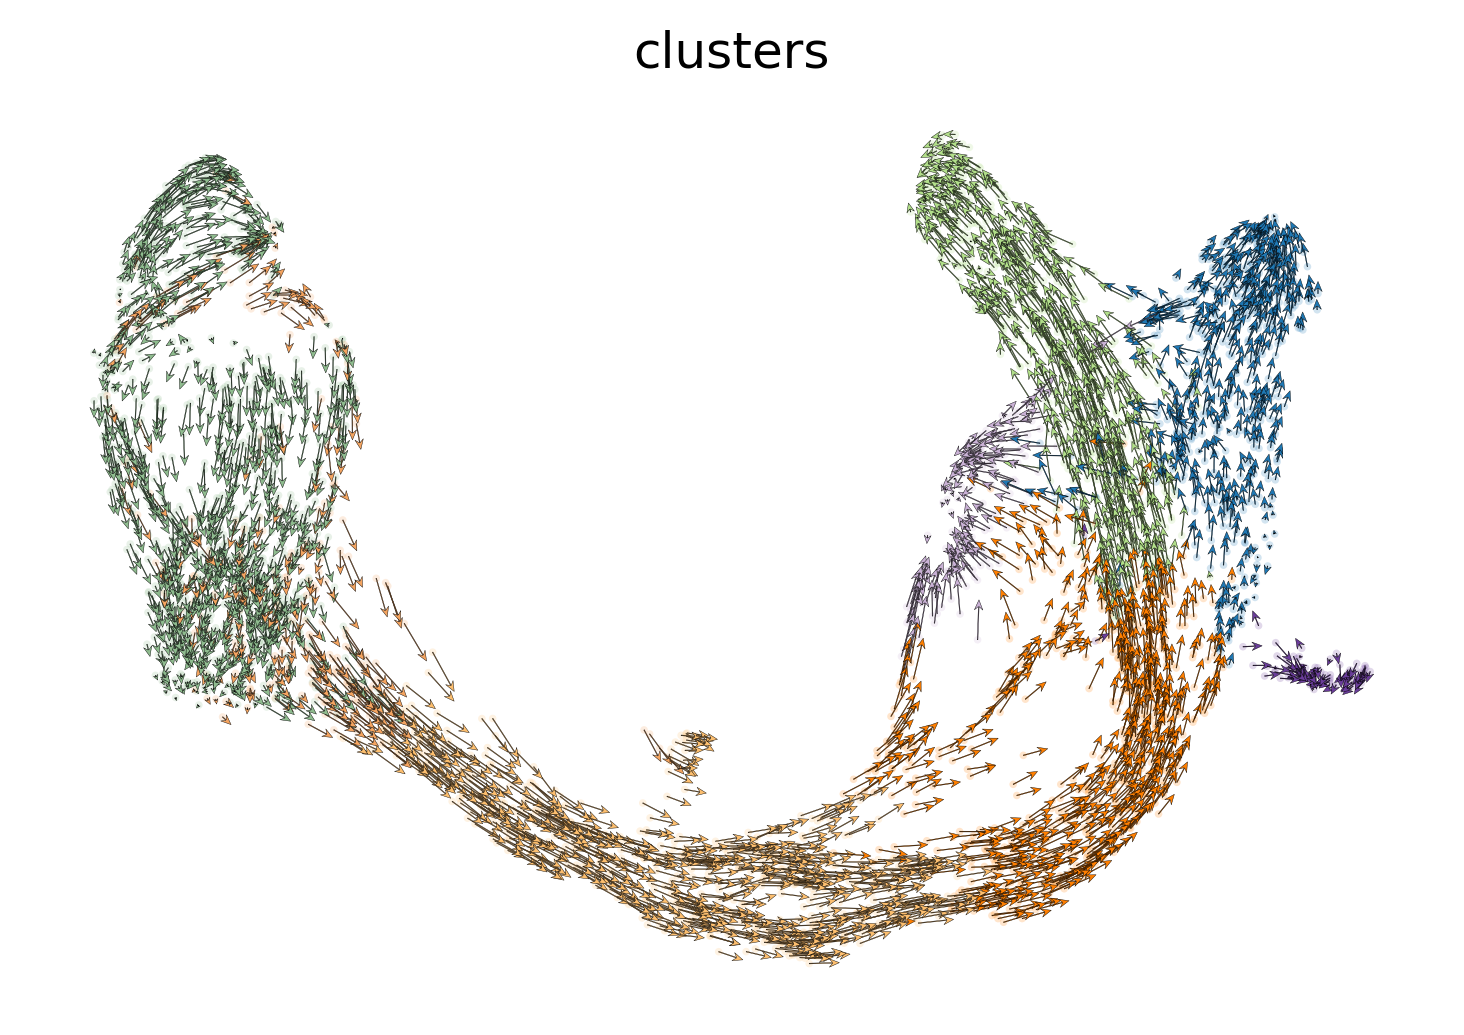

In [7]:
scv.pl.velocity_embedding(
    adata,
    basis="umap",
    arrow_length=9,
    arrow_size=1.2,
    dpi=150,
)


computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


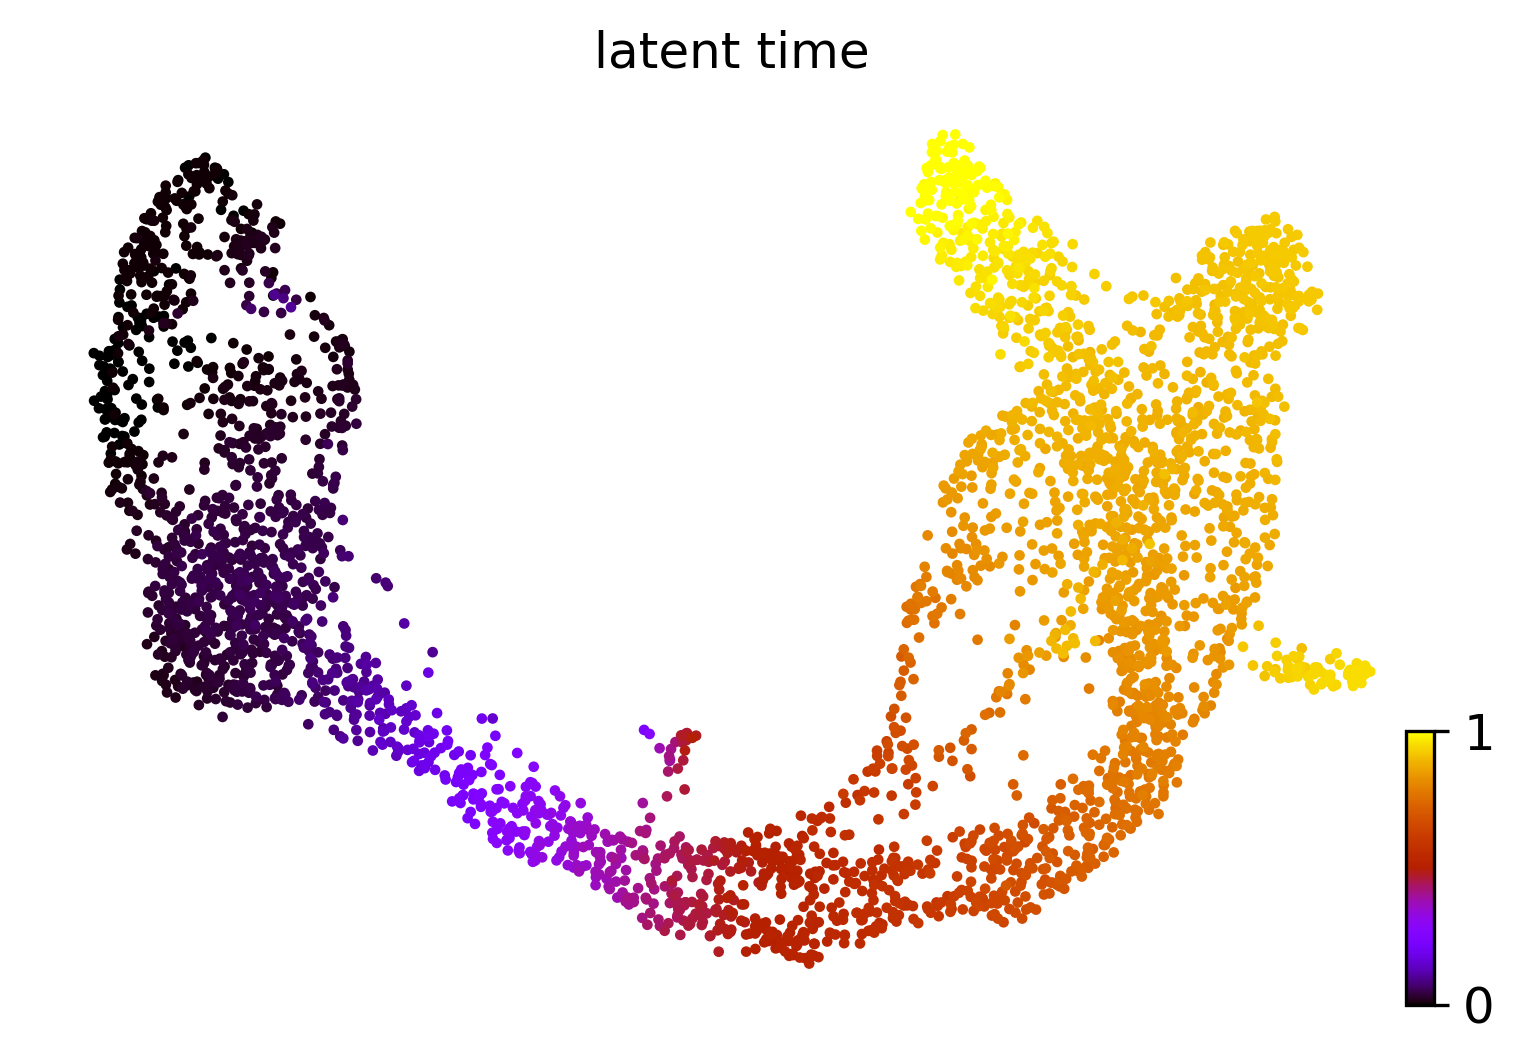

In [8]:
# pseudo-time plot
latent_time(adata)
scv.pl.scatter(
    adata,
    color="latent_time",
    color_map="gnuplot",
    dpi=150,
)


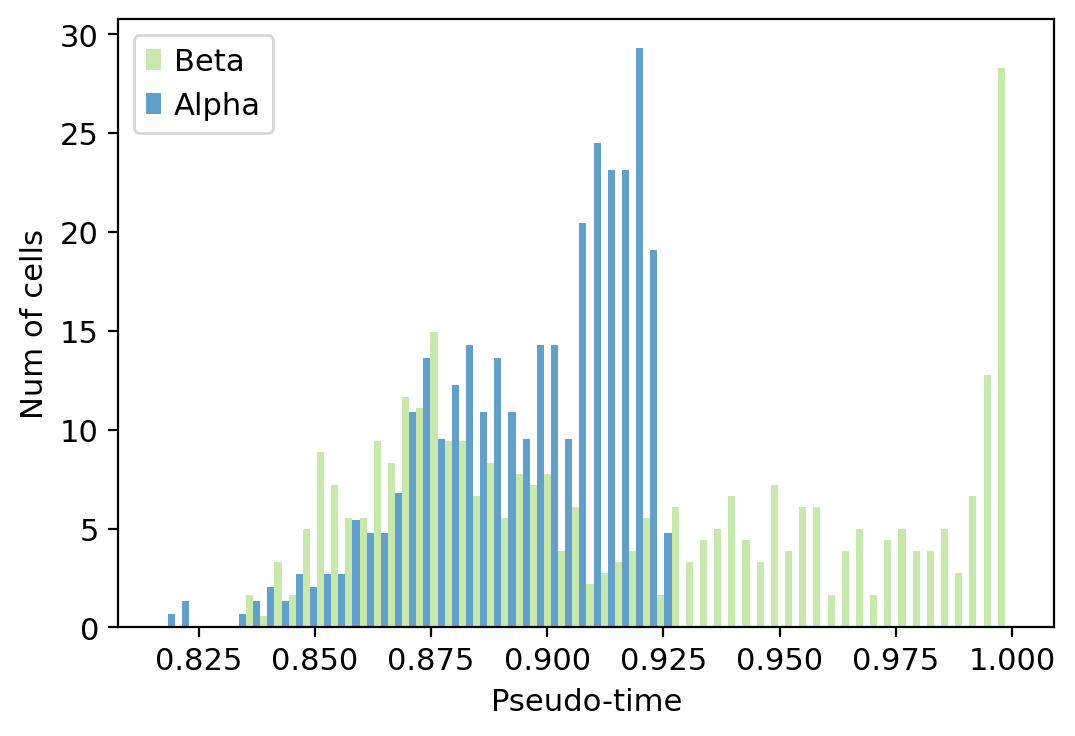

In [9]:
# alpha and beta cell pseudo-time distribution
def _plot_distribution():
    beta_time = adata.obs[adata.obs["clusters"] == "Beta"]["latent_time"]
    beta_time = beta_time.to_numpy()
    alpha_time = adata.obs[adata.obs["clusters"] == "Alpha"]["latent_time"]
    alpha_time = alpha_time.to_numpy()

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(nrows=1, ncols=1)
    colors = adata.uns["clusters_colors"][4:6]
    ax.hist(
        [beta_time, alpha_time],
        bins=60,
        density=True,
        color=colors,
        rwidth=2.0,
        alpha=0.7,
        label=["Beta", "Alpha"],
    )
    ax.set_xlabel("Pseudo-time")
    ax.set_ylabel("Num of cells")
    ax.legend(loc="best")
    plt.show()


_plot_distribution()


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


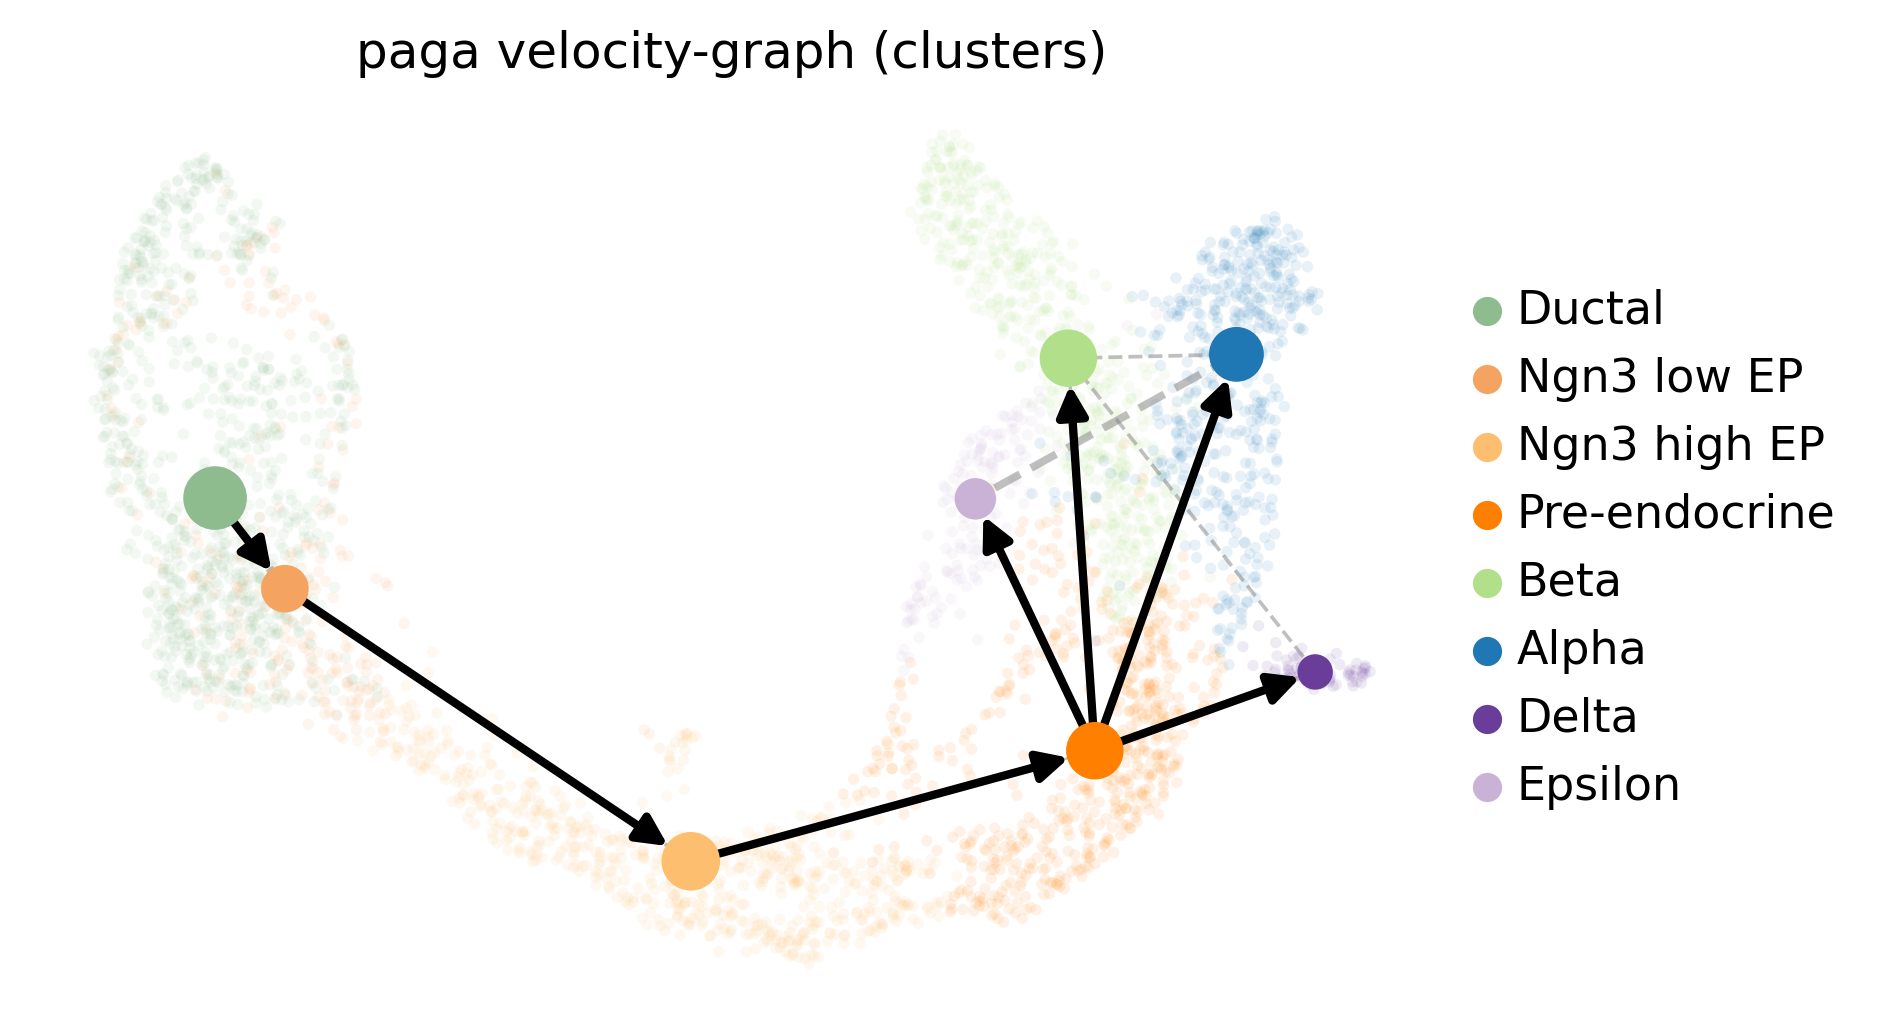

In [10]:
scv.tl.velocity_pseudotime(adata)
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="umap",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150
)

In [11]:
# save adata for next steps
deepvelo_adata = adata.copy()


# scVelo (dynamical)

In [12]:
adata = scv.datasets.pancreas()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [13]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")


recovering dynamics (using 8/8 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:02:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [14]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


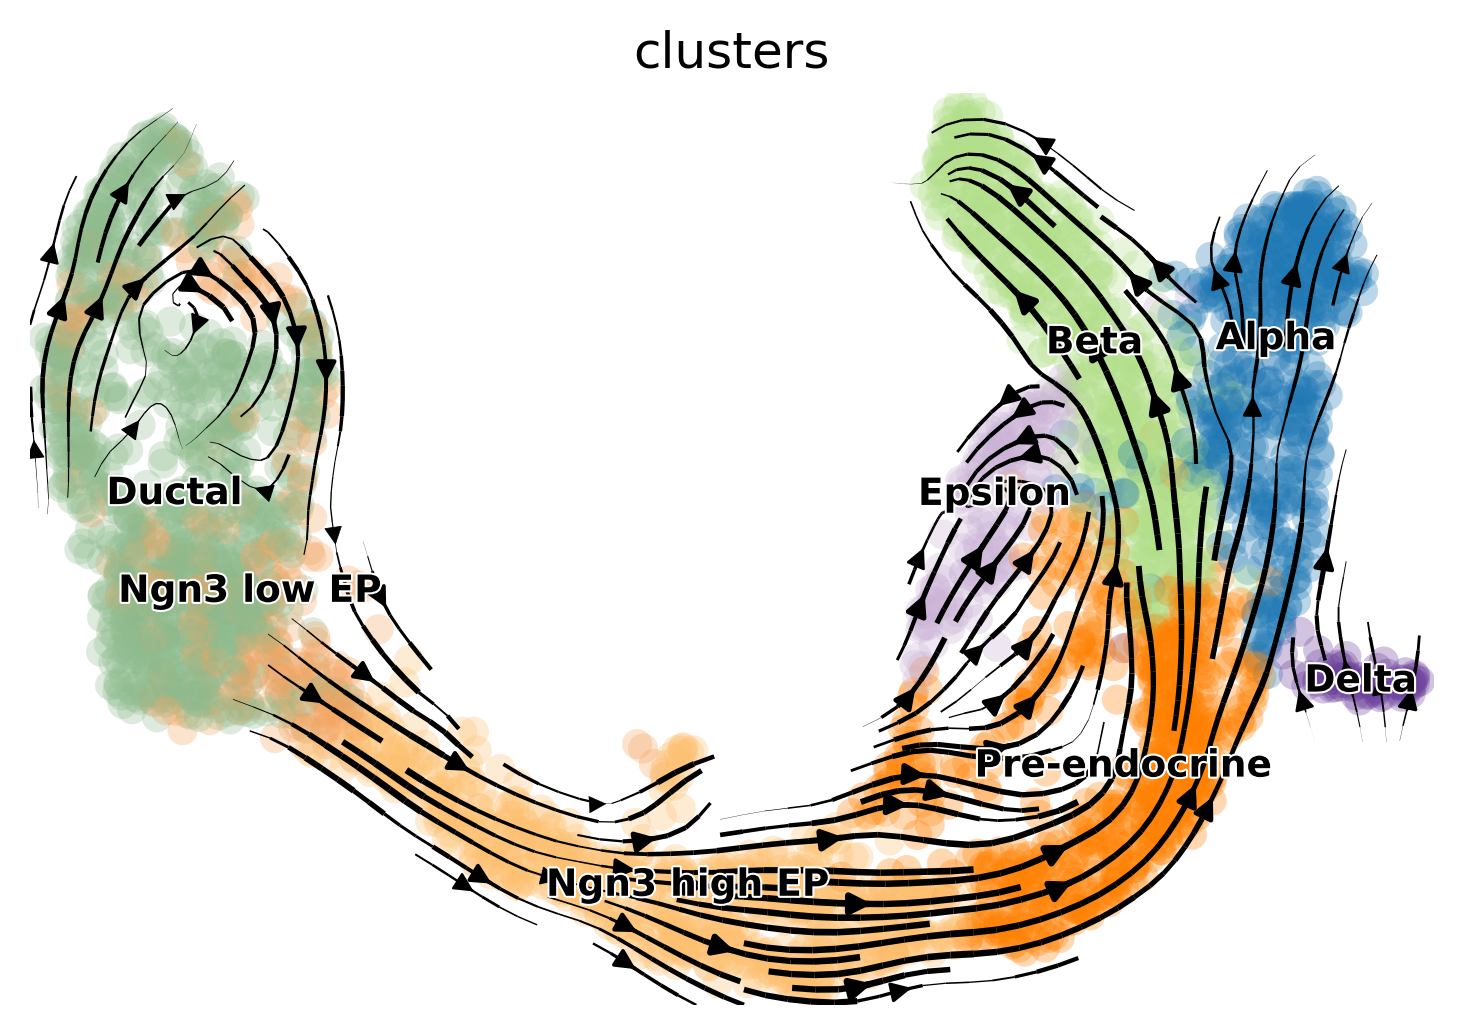

In [15]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    color="clusters",
    legend_fontsize=9,
    dpi=150,
)


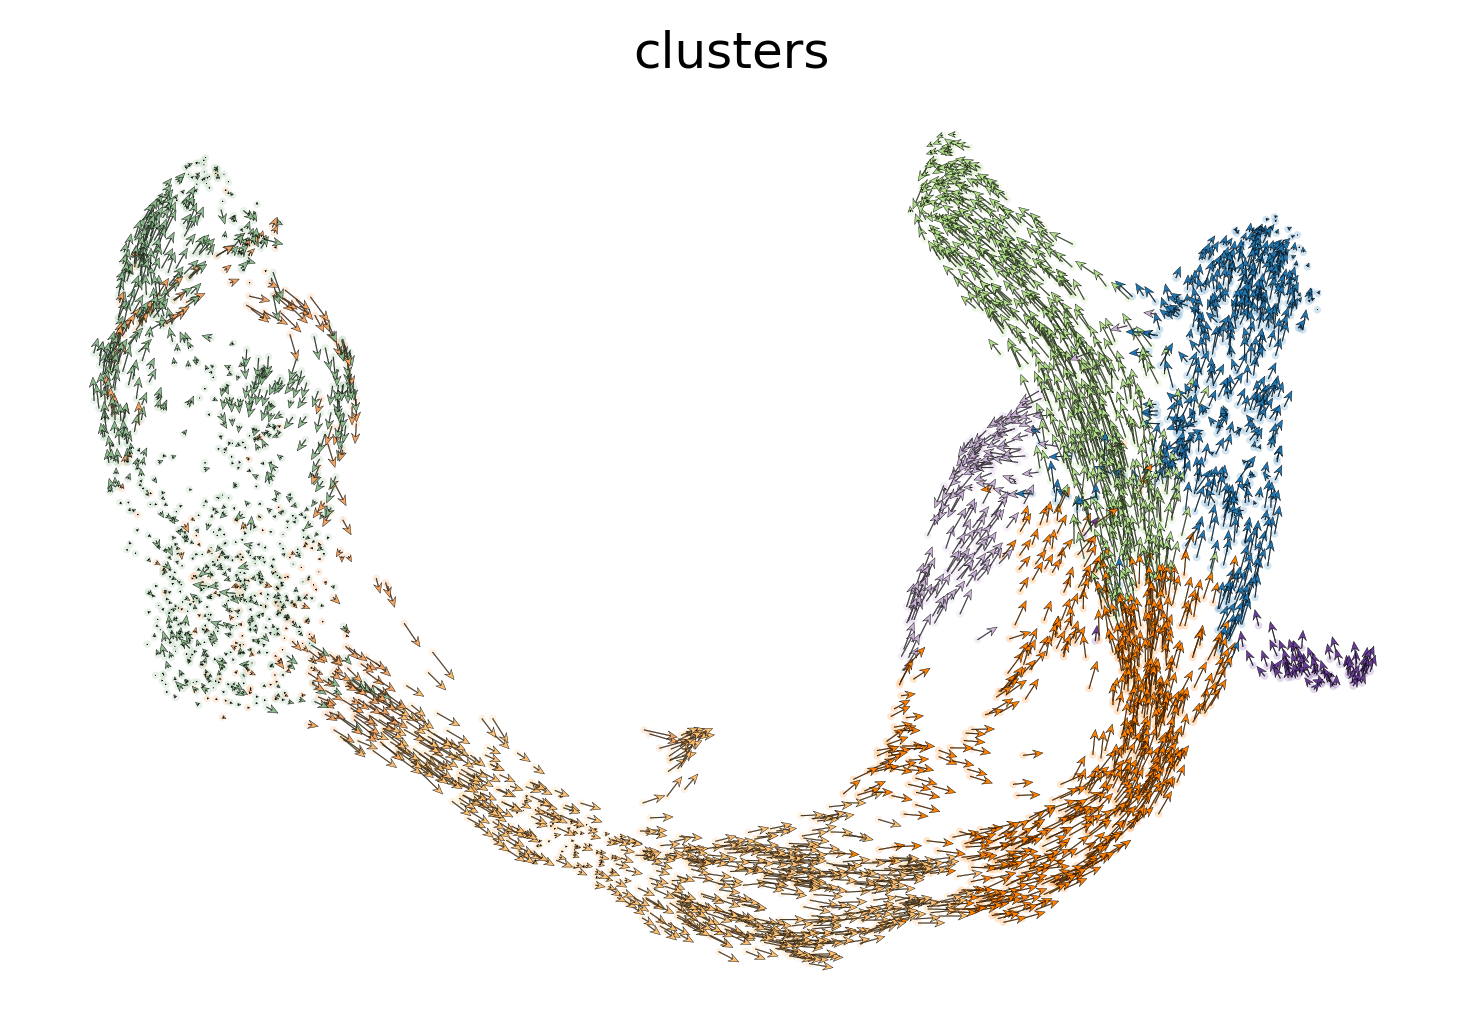

In [16]:
scv.pl.velocity_embedding(
    adata,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=150,
)


computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


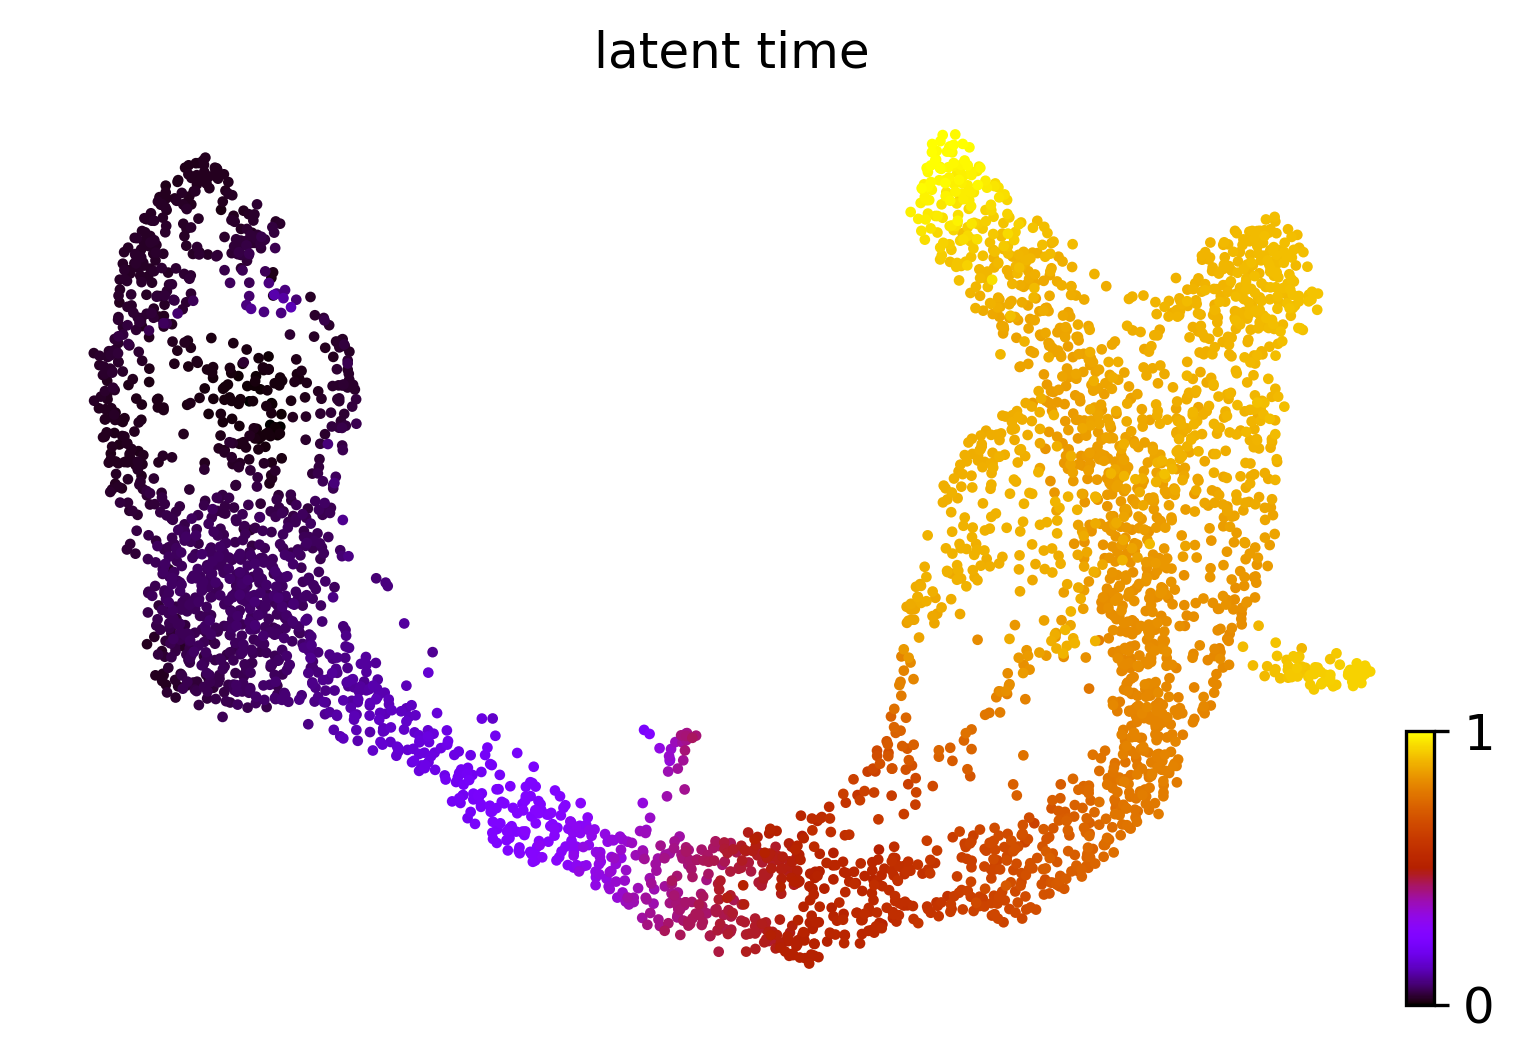

In [17]:
# pseudo-time plot
latent_time(adata)
scv.pl.scatter(
    adata,
    color="latent_time",
    color_map="gnuplot",
    dpi=150,
)


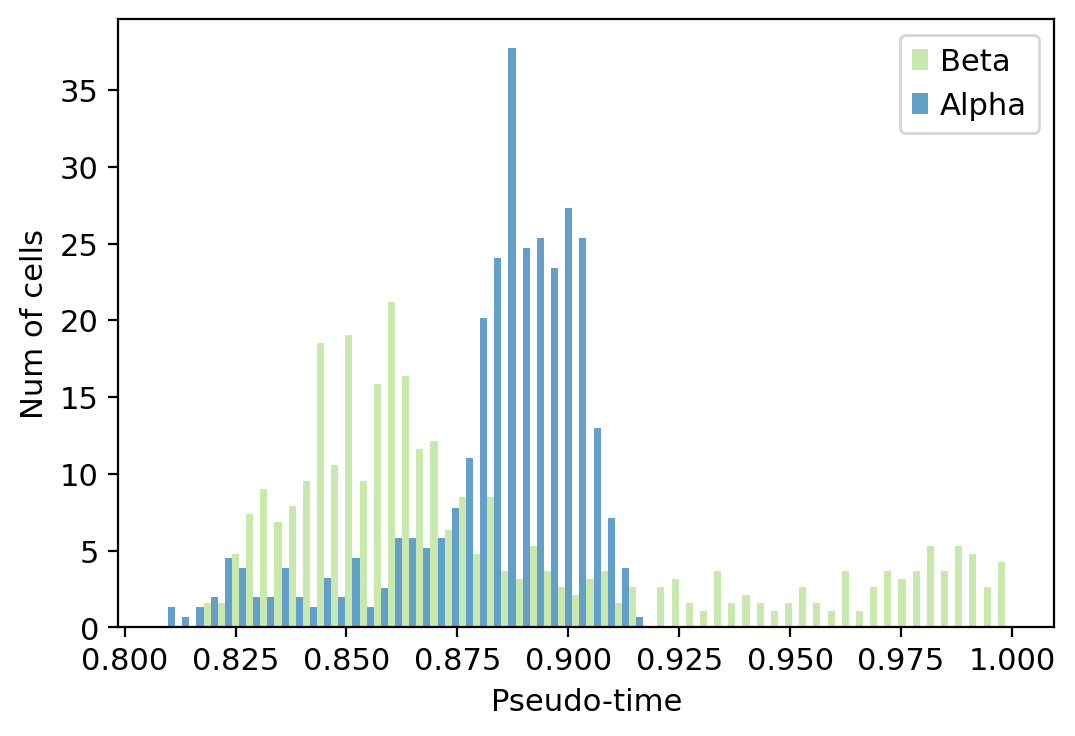

In [18]:
# alpha and beta cell pseudo-time distribution
_plot_distribution()


In [19]:
# save adata for next steps
dynamical_adata = adata.copy()


# Compare consistency score

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.9127, std: 0.0731
Dynamical mean score: 0.8155, std: 0.0818


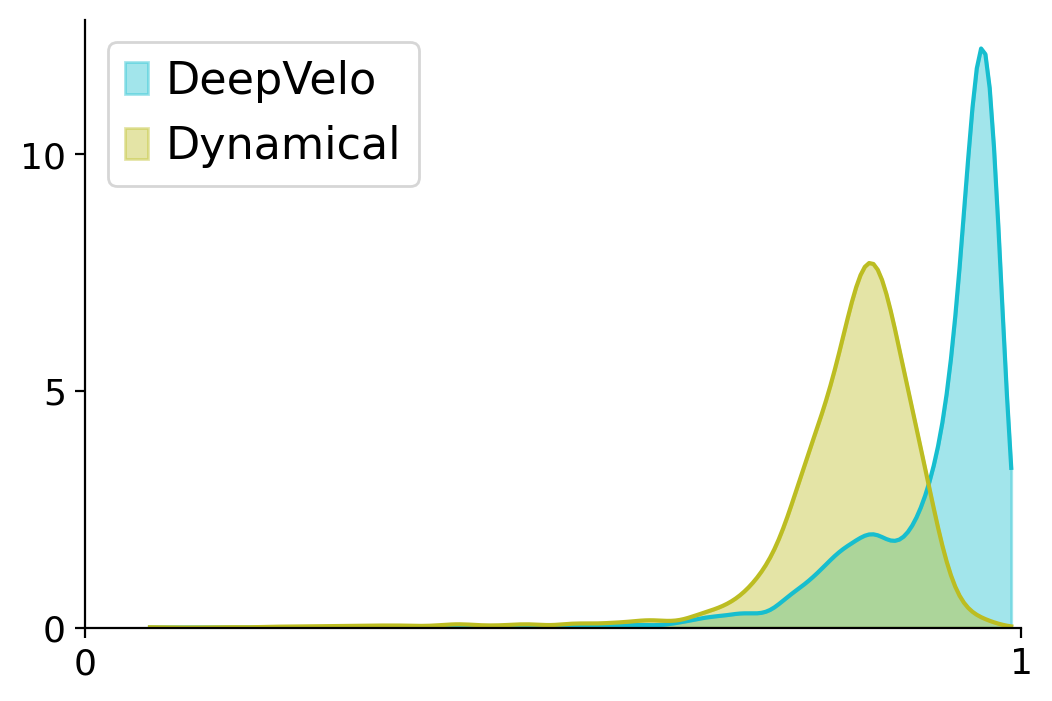

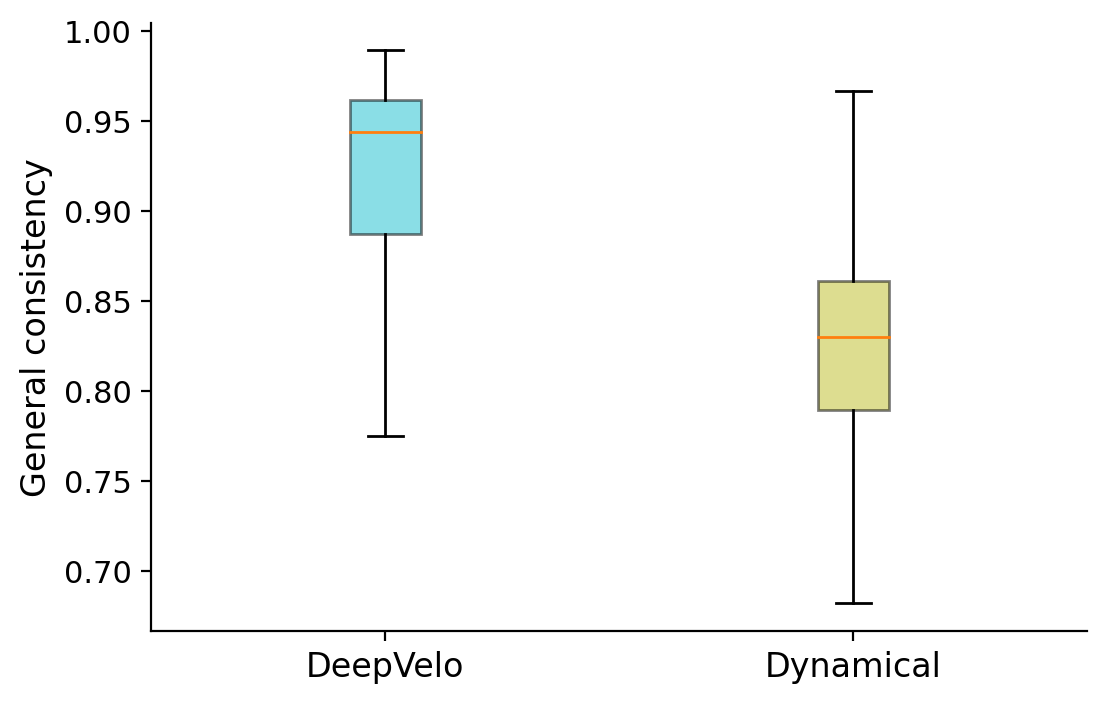

In [20]:
vkey = "velocity"
method = "cosine"
velocity_confidence(deepvelo_adata, vkey=vkey, method=method)
velocity_confidence(dynamical_adata, vkey=vkey, method=method)
compare_plot(deepvelo_adata, dynamical_adata, method=method)

In [21]:
# Mann-Whitney U Test test
stat, p = mannwhitneyu(
    deepvelo_adata.obs["velocity_confidence_cosine"].tolist(),
    dynamical_adata.obs["velocity_confidence_cosine"].tolist(),
)
print(f"Statistics={stat:.3f}, {p}")
# interpret
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")
else:
    print("Different distribution (reject H0)")

Statistics=2005458.000, 0.0
Different distribution (reject H0)


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.6496, std: 0.1251
Dynamical mean score: 0.5100, std: 0.1130


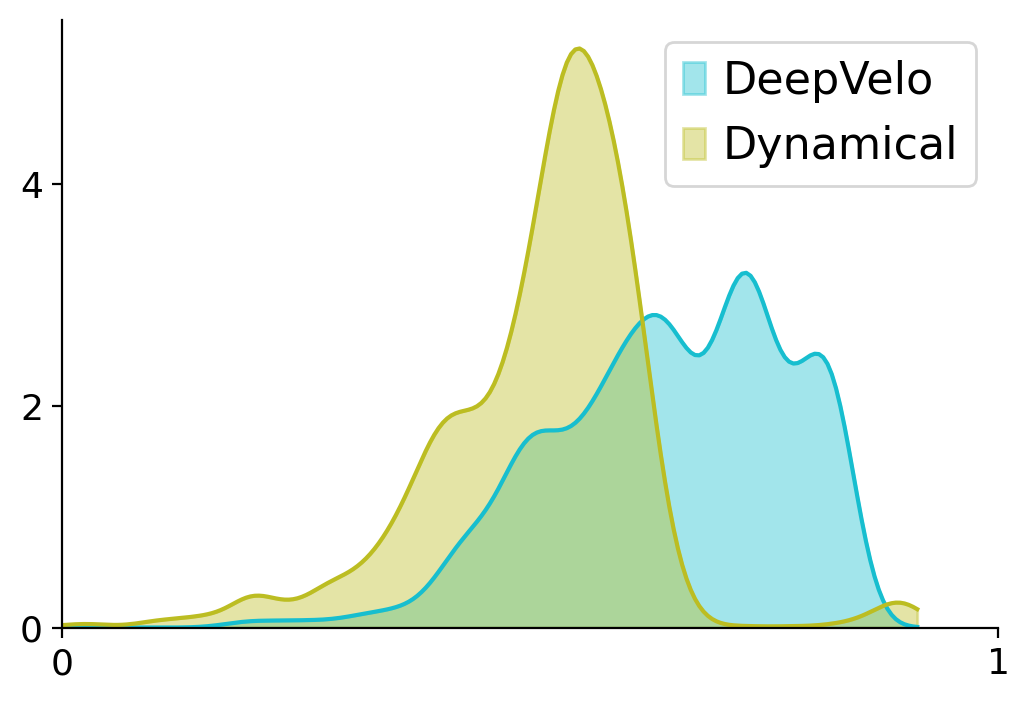

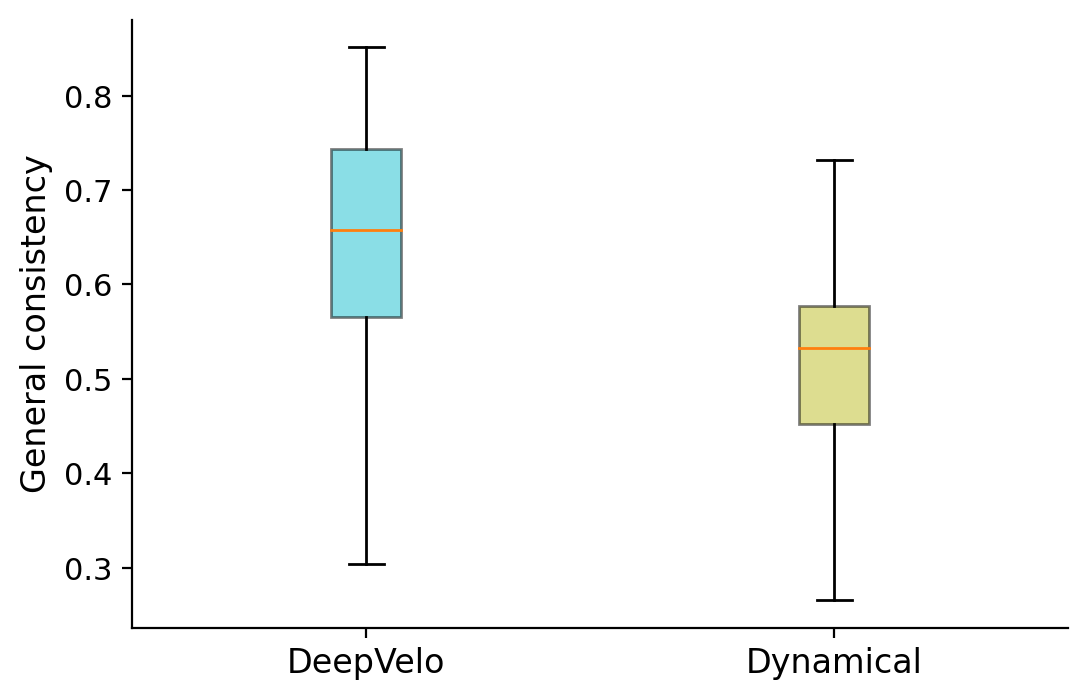

In [22]:
vkey = "velocity"
method = "cosine"
scope_key = "clusters"
# 3. cosine similarity, compute within Celltype
velocity_confidence(deepvelo_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(dynamical_adata, vkey=vkey, method=method, scope_key=scope_key)
compare_plot(deepvelo_adata, dynamical_adata, method=method)

In [23]:
# Mann-Whitney U Test test
stat, p = mannwhitneyu(
    deepvelo_adata.obs["velocity_confidence_cosine"].tolist(),
    dynamical_adata.obs["velocity_confidence_cosine"].tolist(),
)
print(f"Statistics={stat:.3f}, {p}")
# interpret
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")
else:
    print("Different distribution (reject H0)")

Statistics=2696455.000, 0.0
Different distribution (reject H0)
